## 3-1 : Preprocess Mesh for Downscaling
<em>Created by Tomás Cuevas López in 2024, modified by Casey Dietrich in 2024.</em><br>
<br>
This example will show how to preprocess the ADCIRC mesh for use in the downscaling process.<br>
<br>
The downscaling process does two things: (a) increase the resolution of the ADCIRC flood predictions, and (b) extrapolate the water surface until it intersects with the ground surface. For the extrapolation, we extend the water surface by a horizontal distance based on the local mesh resolution.<br>
<br>
There can be situations where the water wants to extend over a long distance. For instance, ADCIRC may not resolve a small channel, so the extrapolation may want to bring the water from the channel mouth all the way upriver. But this extension of the water surface may not be physical. To prevent this, we limit the extrapolation distance to the representative length of the neighboring mesh elements. The water level is allowed to extend to the edge of the next element, or across two neighboring elements, but no farther. This distance is controlled by a parameter called <code>repLenGrowing</code>. (See Example 2 in this folder.)<br>
<br>
Thus the element sizes must be precomputed for use as an input to the downscaling. In this example, we show to preprocess the mesh and create a new raster DEM with the element sizes. <strong>This pre-processing step only needs to be completed once, and then the new raster DEM can be re-used for any downscaling.</strong><br>
<br>
We use files from a simulation of Hurricane Ida, which devastated the south Louisiana coast in 2021. To minimize the file sizes in this repository, we created a small mesh that includes Grand Isle and Barataria Bay. Then we simulated Ida by using the NHC best-track storm parameters in a vortex wind model. The simulated storm effects are meant to be useful as an example, but they should not be relied on for any decision making.

## Preliminaries

In [1]:
import os
import sys
import glob
import shutil
from pathlib import Path
from kalpana.downscaling import meshRepLen2raster
from IPython.display import display, Image

## Mesh Preprocessing

The following cell defines our parameters for the mesh pre-processing. A few things to note:<br>
1. A key input is a DEM with the ground surface elevations. This is the DEM onto which the ADCIRC flood predictions will be downscaled, so the DEM should have the correct coverage and resolution desired by the user. These DEMs can be large -- the DEM for this example is 700 MB, and thus it is too large to host in this GitHub repository. Instead, you can download the example DEM at this Google Drive link:<br>
<br>
<a href="https://drive.google.com/file/d/1t1upA_AsT1s418jdcpdvv-NXqvMViCbH/view?usp=sharing">https://drive.google.com/file/d/1t1upA_AsT1s418jdcpdvv-NXqvMViCbH/view?usp=sharing</a><br>
<br>
and learn how to create DEMs for Kalpana on this page:<br>
<br>
<a href="https://ccht.ccee.ncsu.edu/creating-dems-for-kalpana/">https://ccht.ccee.ncsu.edu/creating-dems-for-kalpana/</a><br>
<br>
2. Note that the user can select the projection (<code>epsgOut</code>) for the new raster DEM with the mesh element sizes. It is good for this projection to be the same as the input DEM with the ground surface elevations, and it is good for both DEMs to use projections with horizontal units of meters or feet (not degrees of longitude/latitude). One possible projection is UTM, for which Kalpana has been tested extensively. However, for this example, the mesh spans the border between two UTM zones (6344 and 6345), and so instead we use a pseudo-Mercator projection (3857) for both DEMs.<br>
<br>
3. Another preprocessing step is to create a GRASS GIS location. Kalpana will do this automatically, but it needs to be able to find GRASS on your system. Please see the instructions in the 'install' folder.

In [2]:
######## For more detail about the meshRepLen2raster inputs, please read the function's docstring.

## Use a Python function to get the path for the current working directory.
cwd = Path(os.getcwd())

## Path of the ADCIRC mesh file (fort.14).
fort14 = str(cwd.parent.parent/'adds'/'ida'/'fort.14')

## Coordinate system of the ADCIRC input.
## Default is 4326 because ADCIRC uses latitude and longitude.
epsgIn = 4326

## Coordinate system of the new raster DEM with the mesh element sizes.
## We use a pseudo-Mercator (3857), but UTM projections (e.g. 6344, 6345) can also work fine.
epsgOut = 3857

## Path of the new raster with the mesh element sizes.
## Kalpana will create both a raster DEM (geoTIFF) and a shapefile.
pathOut = os.path.join(cwd, 'CUDEM_merged_10m_crs3857_mesh.shp') 

## Version of GRASS GIS.
grassVer = 8.3 ## versions 8.2 and 8.3 work

## Path to the folder with the input DEM with the ground surface elevations.
pathRasFiles = str(cwd.parent.parent/'adds'/'ida')

## Name(s) of input DEM(s) with the ground surface elevations.
rasterFiles = 'CUDEM_merged_10m_crs3857.tif'

## Bounding box for the downscaling raster.
## In this example, we will use the same downscaling raster bounding box as the input DEM. 
subDomain = os.path.join(pathRasFiles, rasterFiles) 

## Name of the GRASS location.
nameGrassLocation = None

## True for creating a new location and loading DEMs, false to use an existing location with DEMs already imported.
createGrassLocation = True

## Method for assigning the crs to the grass location.
## Two options 'from_epsg' or 'from_raster' otherwise an error will be thrown.
## In this example, we use the projection from the input DEM.
createLocMethod = 'from_raster'

Now, let's call the <code>meshRepLen2raster</code> function with the parameters we defined. This may take a few minutes, especially if the mesh and/or input DEM are large.

In [6]:
meshRepLen2raster(fort14, epsgIn, epsgOut, pathOut, grassVer, pathRasFiles, rasterFiles, 
                  subDomain=subDomain, nameGrassLocation=nameGrassLocation, 
                  createGrassLocation=createGrassLocation, 
                  createLocMethod=createLocMethod)

2024-07-25 10:26:18.673 | INFO     | kalpana.downscaling:meshRepLen2raster:900 - Mesh created: 0.696 min
2024-07-25 10:26:24.739 | INFO     | kalpana.downscaling:meshRepLen2raster:907 - Clip mesh using subfomain: 0.101 min
2024-07-25 10:27:16.989 | INFO     | kalpana.downscaling:meshRepLen2raster:915 - Export mesh gdf as shapefile: 0.871 min
2024-07-25 10:27:17.128 | INFO     | kalpana.downscaling:meshRepLen2raster:929 -     Start Setup grass environment
2024-07-25 10:27:17.129 | INFO     | kalpana.downscaling:setGrassEnv:346 -         rasters to list:  0.000 min
2024-07-25 10:27:17.339 | INFO     | kalpana.downscaling:setGrassEnv:350 -         create location:  0.003 min
2024-07-25 10:27:17.342 | INFO     | kalpana.downscaling:setGrassEnv:356 -         init grass:  0.000 min
2024-07-25 10:27:21.114 | INFO     | kalpana.downscaling:setGrassEnv:361 -         import raster:  0.063 min
2024-07-25 10:27:21.182 | INFO     | kalpana.downscaling:setGrassEnv:365 -         set downscaling dem: 

The output is a new raster DEM with the mesh element sizes. This DEM is written as both a geoTIFF and a shapefile. The image below shows the new DEM loaded into QGIS -- the element sizes are smallest (darkest gray color) along Grand Isle, the IWW, and other small channels.

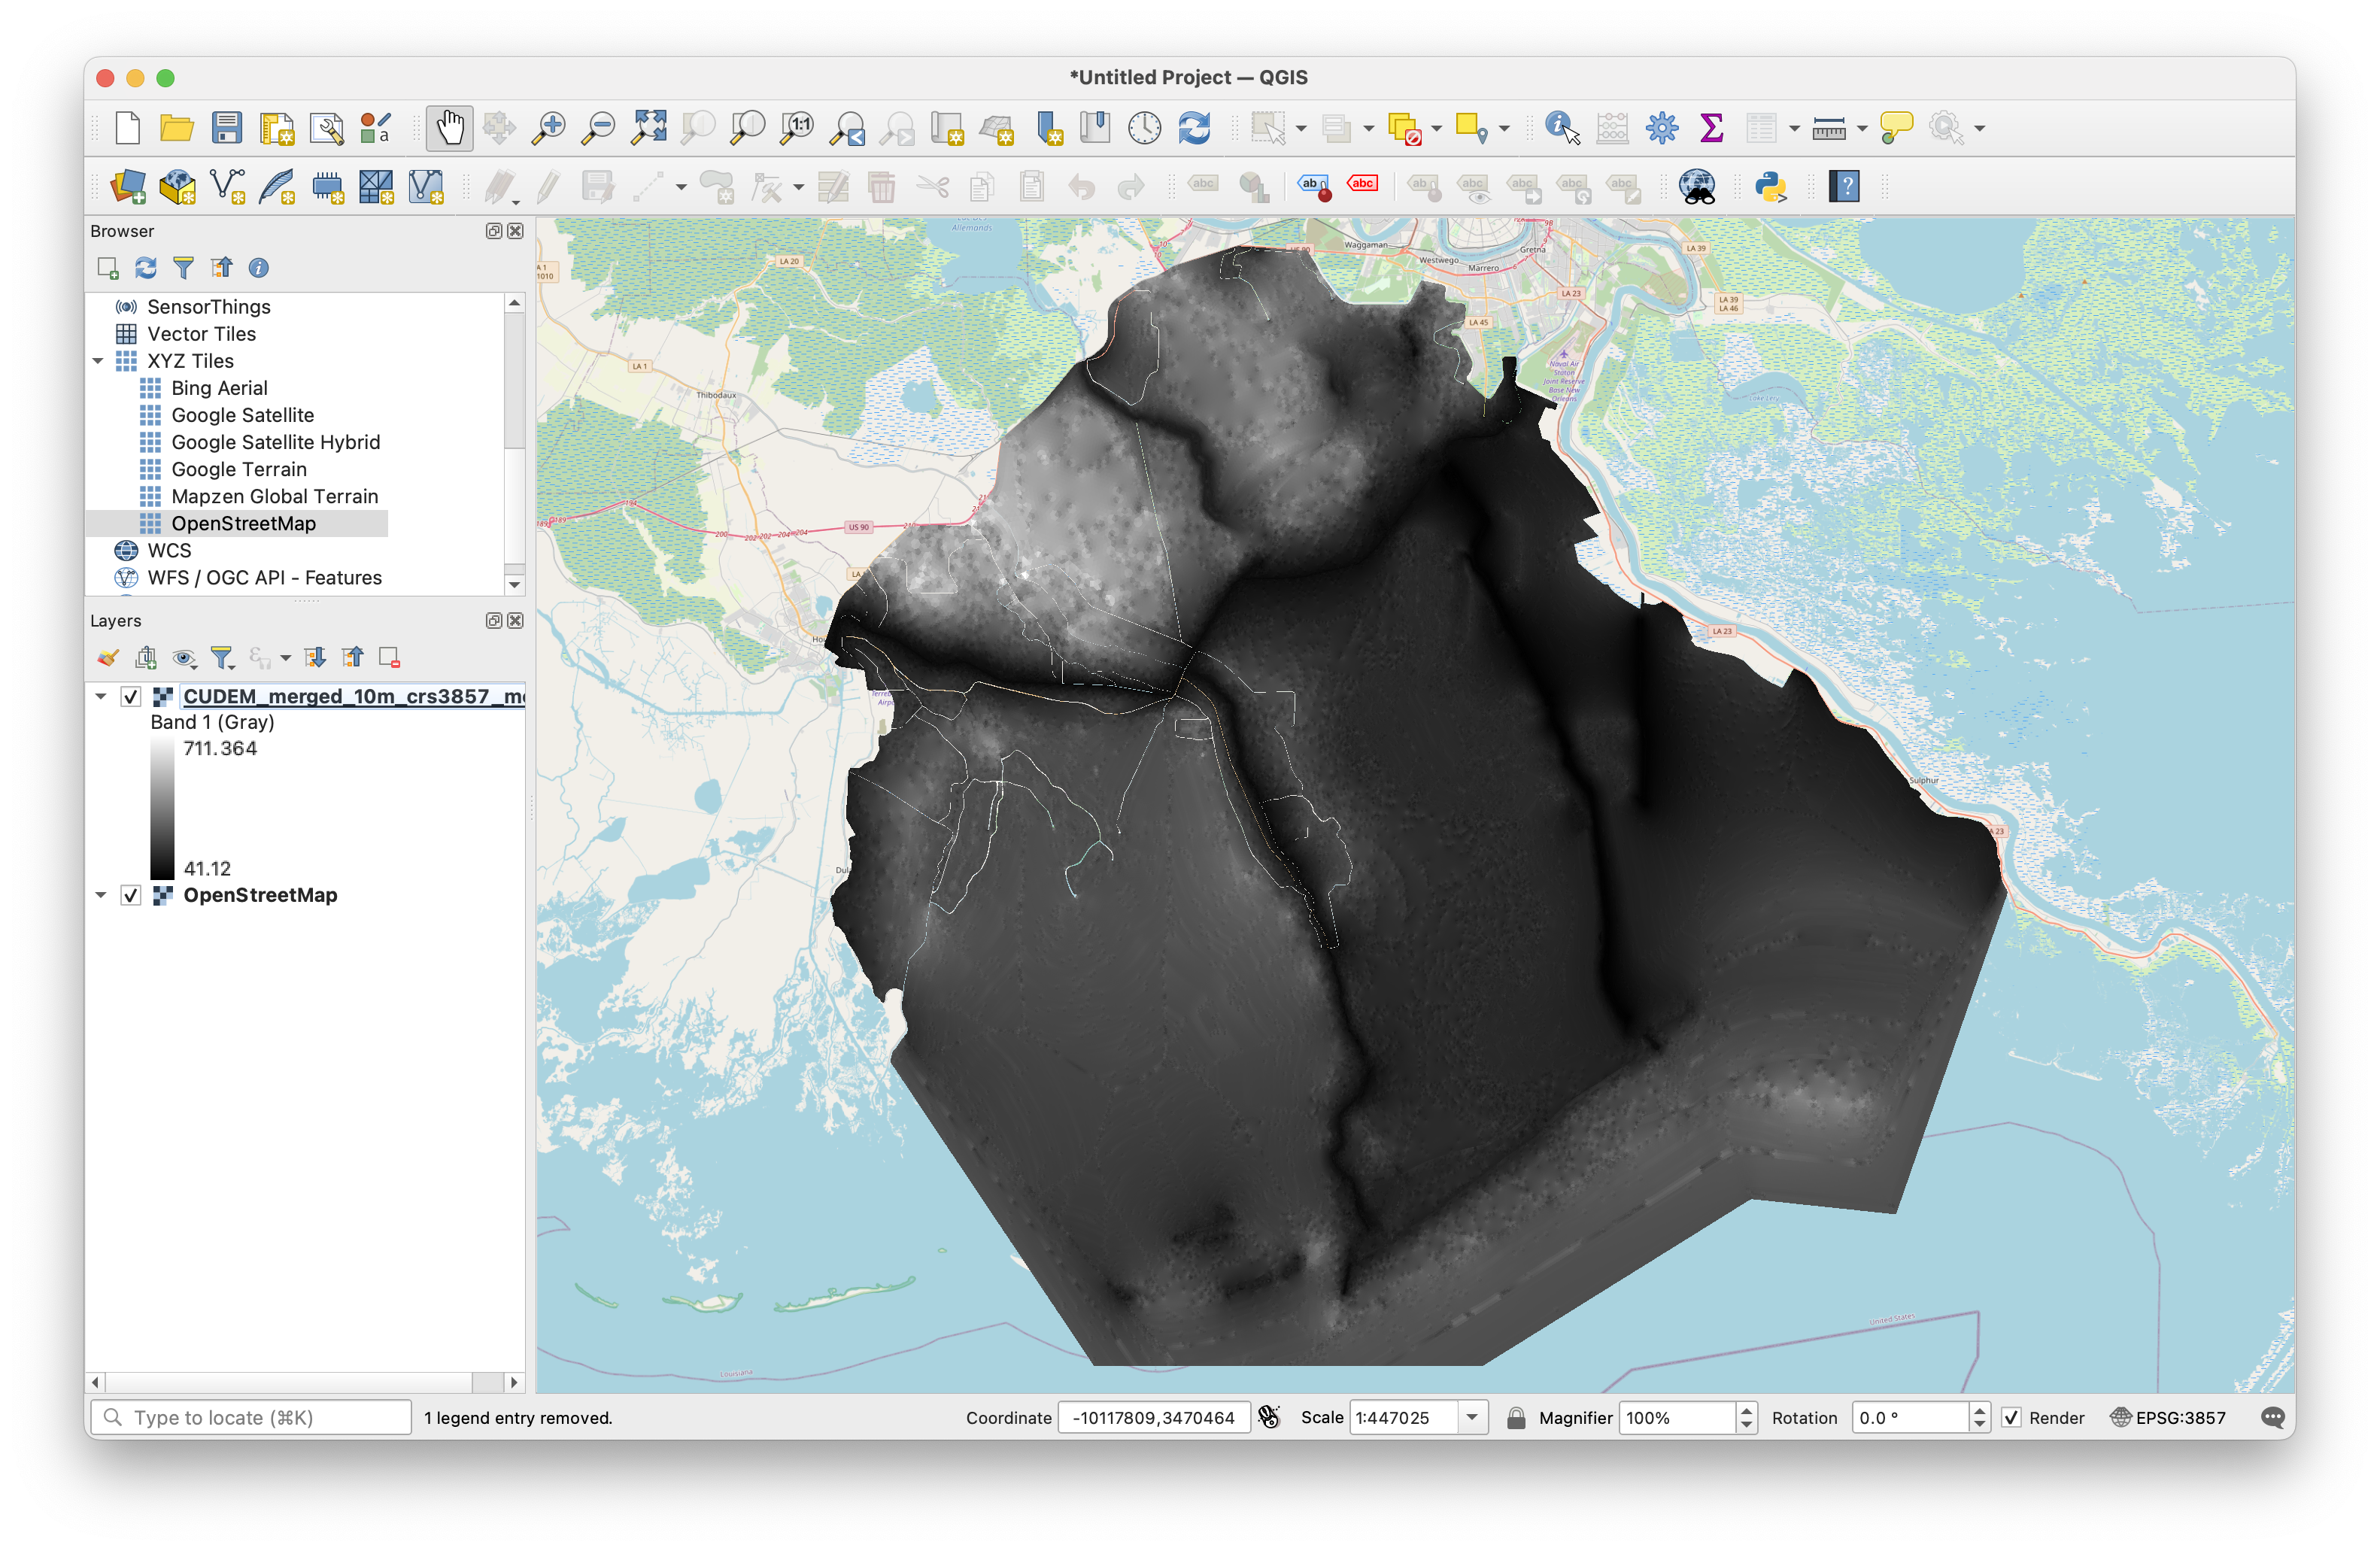

In [4]:
display(Image(filename=r'../../adds/imgs/example_3_1_repLen.png', width = 712))

## Housekeeping

The following cell is optional. We include it to keep clean the repository -- it will delete the shapefile and geoTIFF that we just created, along with the GRASS location. For most users, this cell is not necessary, especially if you want to use those files for downscaling in the next example.

In [7]:
## clean
for f in glob.glob("CUDEM_merged_10m_crs3857_mesh*"):
    os.remove(f)

for f in glob.glob("downscaling_dem*"):
    os.remove(f)

shutil.rmtree('grassLoc')

Good luck with Kalpana! See you in future examples!